In [ ]:
#bridge detection
import cv2
import autocar_module as m
import numpy as np

capture = cv2.VideoCapture('road.mp4')

def get_roi(img):
    mask = np.zeros_like(img)          # 全黑遮罩
    points  = np.array([[[774, 0],     # 建立多邊形座標
                        [0, 0],
                        [0, 308],
                        [355, 391]]])
    cv2.fillPoly(mask, points, 255)    # 多邊三角形
    roi = cv2.bitwise_and(img, mask)
    return roi

def draw_lines(img, lines):                 # 建立自訂函式
    for line in lines:
        points = line.reshape(4,)       # 降成一維 shape = (4,)
        x1, y1, x2, y2 = points         # 取出直線座標
        cv2.line(img,                   # 繪製直線
                 (x1, y1), (x2, y2),
                 (0, 0, 255), 3)
    return img

def get_avglines(lines):
    if lines is None:                   # 如果有找到線段
        print('偵測不到直線線段')
        return None
    #-----↓先依斜率分到左組或右組↓
    lefts = []
    rights = []
    for line in lines:
        points = line.reshape(4,)
        x1, y1, x2, y2 = points
        slope, b = np.polyfit((x1, x2), (y1, y2), 1)  # y = slope*x + b
        # print(f'y = {slope} x + {b}')  #若有需要可將斜率與截距印出
        if slope > 0:   # 斜率 > 0, 右邊的直線函數
            rights.append([slope, b])  # 以 list 存入
        else:       # 斜率 < 0, 左邊的直線函數
            lefts.append([slope, b])  # 以 list 存入

    #-----↓再計算左組與右組的平圴線↓
    if rights and lefts:     # 必須同時有左右兩邊的直線函數
        right_avg = np.average(rights, axis=0)    # 取得右邊的平均直線
        left_avg = np.average(lefts, axis=0)      # 取得左邊的平均直線
        return np.array([right_avg, left_avg])
    else:
        print('無法同時偵測到左右邊緣')
        return None
    
def get_sublines(img, avglines):
    sublines = []                   # 用於儲存線段座標
    for line in avglines:       # 一一取出所有直線函數
        slope, b = line         # y = slope*x + b
        y1 = 0         # 影像高度 (即影像的最底部位
        y2 = int(y1+img.shape[0]*(0.45))       # 取影像高度的 0.45 位置為線段
        x1 = int((y1 - b) / slope) # x = (y-b/m), 取得線段 x 座標
        x2 = int((y2 - b) / slope)
        sublines.append([x1, y1, x2, y2])  # 座標存入串列中
    return np.array(sublines)       # 將串列轉為陣列回傳

if capture.isOpened():
    while True:
        sucess, img = capture.read()
        if sucess:
            edge = m.get_edge(img)
            roi = get_roi(edge)
            lines = cv2.HoughLinesP(image = roi,
                                rho = 1.5,
                                theta = np.pi/180,
                                threshold = 100,
                                minLineLength = 50,
                                maxLineGap = 100)
            
            avglines = get_avglines(lines)
            if avglines is not None:
                lines = get_sublines(img, avglines)
                img = draw_lines(img, lines)
            cv2.imshow("Frame", img)
        k = cv2.waitKey(1)
        if k == ord('q') or k == ord("Q"):
            print("exit")
            cv2.destroyAllWindows()
            capture.release()
            break
else:
    print("Fail to open camera")   

Predictions for the testing data: [1 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1 0 0 1 1
 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0
 1 1 0]
Prediction score: 0.956140350877193
Accuracy score: 0.956140350877193
Training score: 0.9406593406593406
Testing score: 0.956140350877193
Cross validation score: 0.9016308376575242


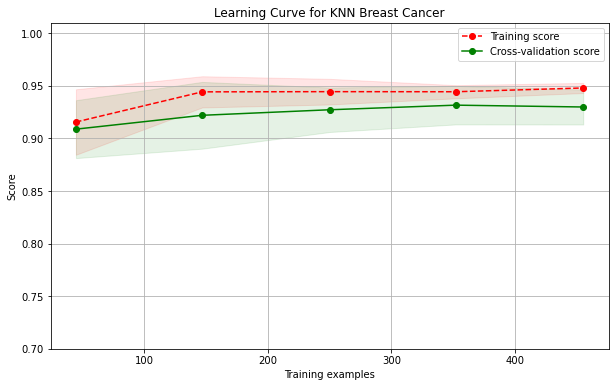

In [1]:
#KNN
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.metrics import accuracy_score

data=load_breast_cancer()

X = data.data
y = data.target
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

knn = KNeighborsClassifier(n_neighbors = 5) 
knn_model=knn.fit(x_train, y_train)

#Prediction test
#Prints the predicted values of the test set
#for the tumor class (malignant or benign)
predictions=knn.predict(x_test)
print('Predictions for the testing data:', predictions)

#Prediction score
print("Prediction score:", knn.score(x_test, y_test))
print("Accuracy score:", accuracy_score(y_test, predictions))



#Cross validation score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

knn = KNeighborsClassifier(n_neighbors = 5) 
knn_model=knn.fit(x_train, y_train)
kfold = KFold(n_splits=2)
cv_results = cross_val_score(knn, X, y, cv=kfold, scoring ='accuracy')
print("Training score:", knn_model.score(x_train, y_train))
print("Testing score:" , knn_model.score(x_test, y_test))
print("Cross validation score:", cv_results.mean())





def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                       n_jobs=1, train_sizes=np.linspace(.1,1.0,5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1,
                    color="g")
    plt.plot(train_sizes, train_scores_mean, 'o--', color= "r",
            label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label= "Cross-validation score")
    plt.legend(loc="best")
    return plt




#Learning curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

knn = KNeighborsClassifier(n_neighbors=5)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plt.figure(figsize=(10,6))
plot_learning_curve(knn, "Learning Curve for KNN Breast Cancer",
                   X, y, ylim= (0.7,1.01), cv=cv);



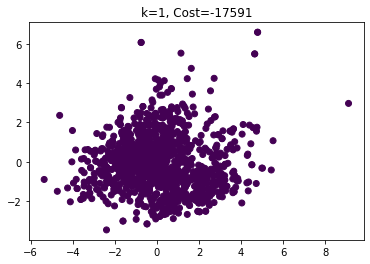

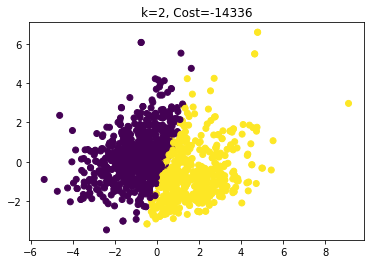

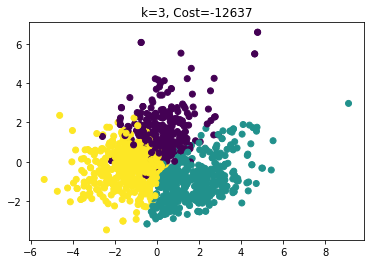

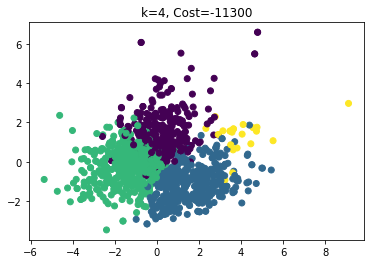

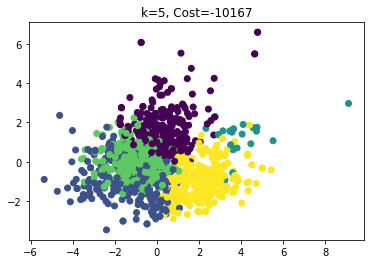

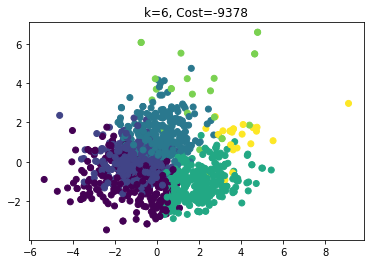

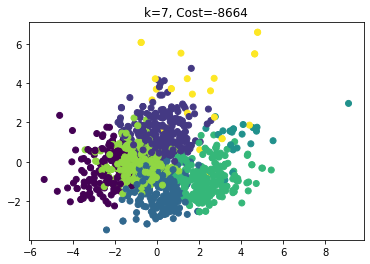

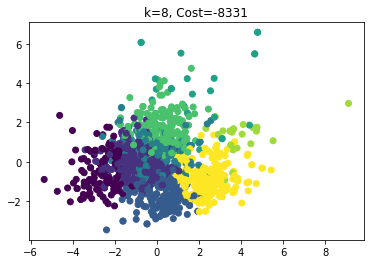

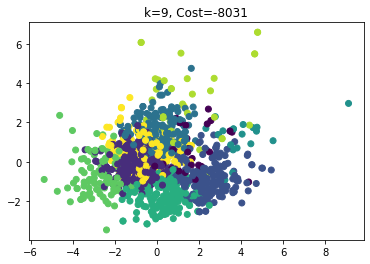

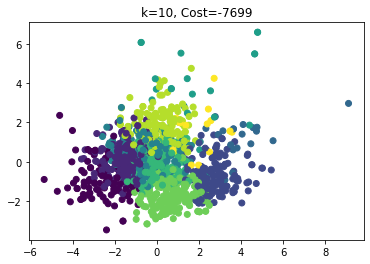

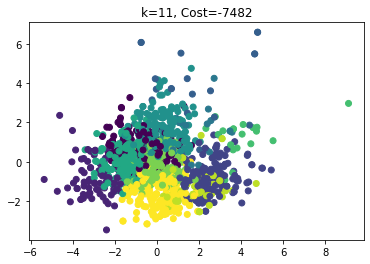

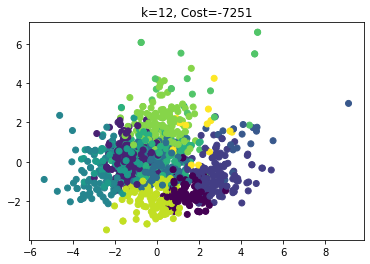

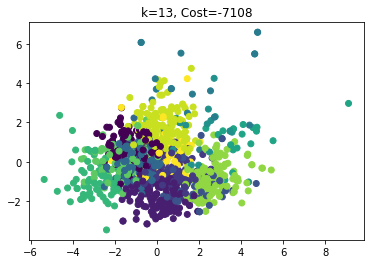

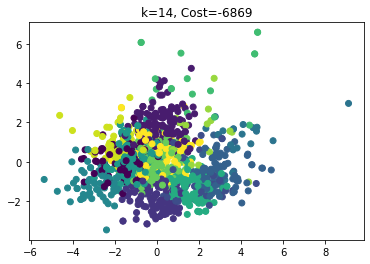

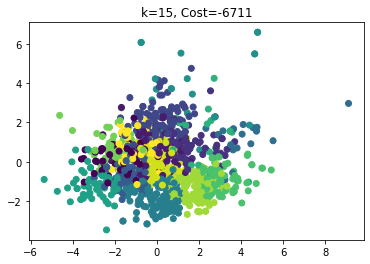

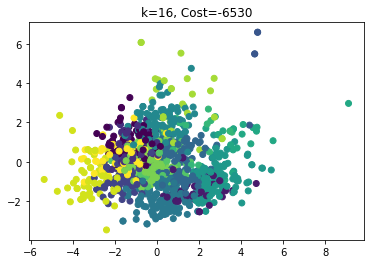

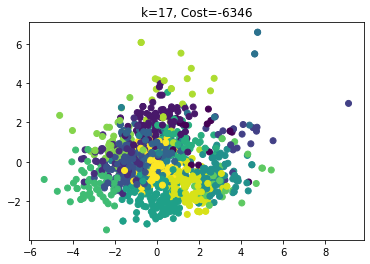

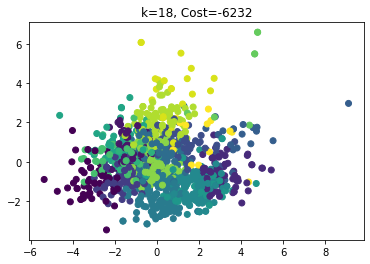

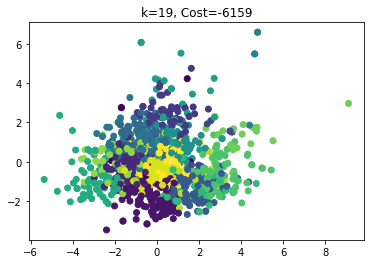

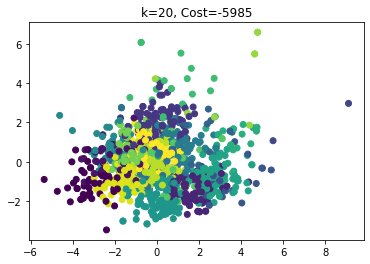

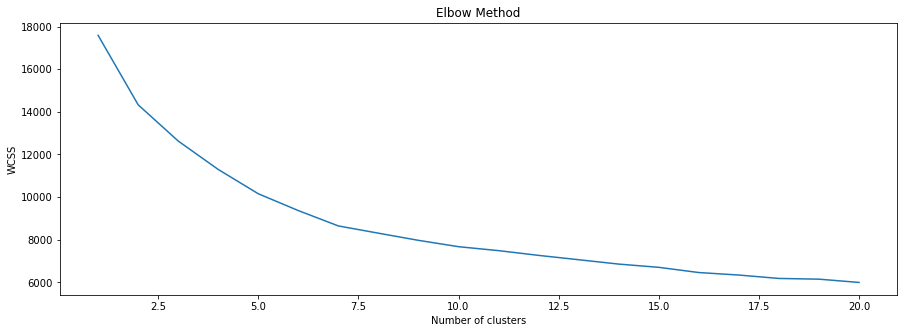

In [5]:
#Clustering
%matplotlib inline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


data= pd.read_csv('C:/Users/gametogo/Desktop/dataset/winequality-red.csv')
X = data.drop('quality', axis=1)



pred = data[["density", 'alcohol', 'sulphates', 'pH', 'volatile acidity', 'chlorides', 'fixed acidity',
                   'citric acid', 'residual sugar', 'free sulfur dioxide', 'total sulfur dioxide']]
X = pd.DataFrame(preprocessing.scale(X))
X.columns = pred.columns

train_set, test_set = train_test_split(X, test_size=0.2, random_state =42)

for k  in range(1,21):
    kmean = KMeans(n_clusters=k)
    kmean.fit(train_set)
    
# plot the clusters
    pca_2 = PCA(2)
    plot_columns = pca_2.fit_transform(train_set)
    plt.scatter(x=plot_columns[:, 0], y=plot_columns[:, 1], c=kmean.labels_)
    score = kmean.score(X)
    plt.title("k={}, Cost={}".format(k, (int)(score)))
    plt.show()

#plot the wcss
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(15, 5))
plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()